# Load Database Tables into Python

In [4]:
# Import Dependencies
import sqlalchemy
from sqlalchemy import create_engine
from config import db_password_susie
import pandas as pd

In [2]:
# Import dependencies
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation
from keras.utils import to_categorical
from keras.layers.advanced_activations import LeakyReLU

import matplotlib.pyplot as plt
import numpy as np


Using TensorFlow backend.


In [6]:
# read data from Postgres Database
engine = create_engine('postgresql://postgres:'+ db_password_susie +'@localhost:5432/AI_Music_DB')

notes_df = pd.read_sql_table('Notes_Spectrogram_Table',engine)
notes_df.head(3)

,index,Spectrogram,File_Path,Pitch,Note,Octave
0,0,"[[0.0302155, 0.0884004, 0.0677238, 0.107217, 0...",Brass/Bass_Tuba/ordinario/BTb-ord-F#1-pp-N-N.wav,F#1,F#,1
1,1,"[[0.31084, 0.610447, 0.0660826, 0.0801414, 0.0...",Brass/Bass_Tuba/ordinario/BTb-ord-G1-pp-N-R100...,G1,G,1
2,2,"[[0.0337471, 0.239179, 0.030329, 0.00971422, 0...",Brass/Bass_Tuba/ordinario/BTb-ord-G#1-pp-N-T16...,G#1,G#,1


In [7]:
# Convert Spectrograms from list to ndarray
notes_df['Spectrogram'] = notes_df['Spectrogram'].apply(lambda x: np.array(x))

type(notes_df['Spectrogram'].iloc[0])

numpy.ndarray

# MODEL - Neural Network 

In [8]:
# Create train and test data sets
X_series = notes_df["Spectrogram"]
y = notes_df["Note"]

In [9]:
# Parameters
channels = 1 # number of audio channels
spectrogram_shape = X_series[1].shape + (channels,)
batch = spectrogram_shape[1]

In [10]:
X_series.shape

(2913,)

In [11]:
count = 0

for i in X_series[1]:
    count =+ 1

count

1

In [13]:
# Reshape X into size of spectrogram and convert to ndarray
X = np.array([i.reshape( (spectrogram_shape) ) for i in X_series])
X.shape

(2913, 22, 128, 1)

In [14]:
# Encode pitches

le = LabelEncoder() 
y = le.fit_transform(y)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

# Reshape for model
# X_train = np.array([X.reshape(20, 20, 1) for x in X_train])
# X_test = np.array([X.reshape(20, 20, 1) for x in X_test])

# onehotencoder = OneHotEncoder() 
y_test_hot = to_categorical(y_test)
y_train_hot = to_categorical(y_train)

In [15]:
# Troubleshooting queries
type(X_train[1])
X_train[1].shape
# X_train[1]

(22, 128, 1)

In [16]:
# Model
notes_model = Sequential()
notes_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(spectrogram_shape),padding='same'))
notes_model.add(LeakyReLU(alpha=0.1))
notes_model.add(MaxPooling2D((2, 2),padding='same'))
notes_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
notes_model.add(LeakyReLU(alpha=0.1))
notes_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
notes_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
notes_model.add(LeakyReLU(alpha=0.1))                  
notes_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
notes_model.add(Flatten())
notes_model.add(Dense(128, activation='linear'))
notes_model.add(LeakyReLU(alpha=0.1))                  
notes_model.add(Dense(12, activation='softmax'))

In [17]:
notes_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [16]:
# notes_model.summary()

In [18]:
notes_train = notes_model.fit(X_train, y_train_hot, batch_size=batch,epochs=8,verbose=1,validation_data=(X_test, y_test_hot))

Train on 2184 samples, validate on 729 samples
Epoch 1/8
2184/2184 [==============================] - 9s 4ms/step - loss: 2.2579 - accuracy: 0.3155 - val_loss: 1.7087 - val_accuracy: 0.4225
Epoch 2/8
2184/2184 [==============================] - 8s 4ms/step - loss: 0.8829 - accuracy: 0.7349 - val_loss: 0.5687 - val_accuracy: 0.8258
Epoch 3/8
2184/2184 [==============================] - 8s 4ms/step - loss: 0.4836 - accuracy: 0.8585 - val_loss: 0.4022 - val_accuracy: 0.8724
Epoch 4/8
2184/2184 [==============================] - 8s 4ms/step - loss: 0.3079 - accuracy: 0.9043 - val_loss: 0.3434 - val_accuracy: 0.8903
Epoch 5/8
2184/2184 [==============================] - 8s 4ms/step - loss: 0.2254 - accuracy: 0.9313 - val_loss: 0.2916 - val_accuracy: 0.9053
Epoch 6/8
2184/2184 [==============================] - 8s 4ms/step - loss: 0.1790 - accuracy: 0.9464 - val_loss: 0.2818 - val_accuracy: 0.9136
Epoch 7/8
2184/2184 [==============================] - 8s 4ms/step - loss: 0.1500 - accuracy: 0

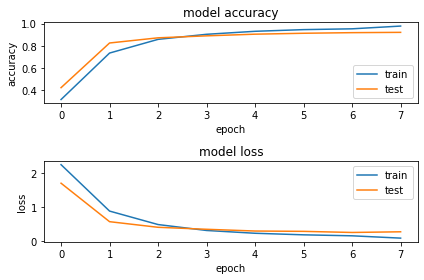

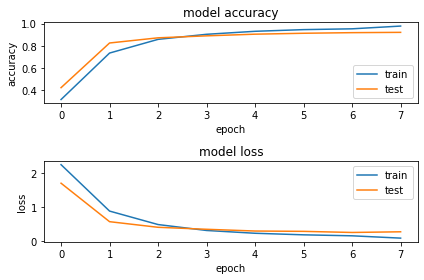

In [19]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(notes_train.history['accuracy'])
plt.plot(notes_train.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.subplot(2,1,2)
plt.plot(notes_train.history['loss'])
plt.plot(notes_train.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()
fig

In [20]:
# Export our model to HDF5 file
import os
os.makedirs('../Result_models/',exist_ok=True)

# save trained model
notes_model.save("../Result_models/trained_notes_model.h5", overwrite=True)